In [1]:
# set up autoreload
%reset
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from dataset import DataManager, FrameDataGenerator

# check gpu
print(tf.sysconfig.get_build_info())
print(tf.config.list_physical_devices('GPU'))
print(tf.config.list_physical_devices())


2023-12-05 20:29:31.840983: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-05 20:29:33.326475: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/ji/anaconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


OrderedDict([('cpu_compiler', '/dt9/usr/bin/gcc'), ('cuda_compute_capabilities', ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']), ('cuda_version', '11.8'), ('cudnn_version', '8'), ('is_cuda_build', True), ('is_rocm_build', False), ('is_tensorrt_build', True)])
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-12-05 20:29:34.884200: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-05 20:29:35.143775: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-05 20:29:35.144539: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [3]:
# set up data generator
data_manager = DataManager(
        data_path=r"/home/ji/Dropbox/Robotics/ENPM809K_Fundamentals_in_AI_and_DL/Data",
        train_val_test_split=(0.80,0.1,0.1))

data_manager_small = DataManager(
        data_path=r"/home/ji/Dropbox/Robotics/ENPM809K_Fundamentals_in_AI_and_DL/Data_Test",
        train_val_test_split=(1.0,0.0,0.0))

2023-12-05 20:29:49.913 | INFO     | dataset:__init__:29 - Found video file: /home/ji/Dropbox/Robotics/ENPM809K_Fundamentals_in_AI_and_DL/Data/Data_2023-11-06_09-22-28.avi
2023-12-05 20:29:49.914 | INFO     | dataset:__init__:29 - Found video file: /home/ji/Dropbox/Robotics/ENPM809K_Fundamentals_in_AI_and_DL/Data/Data_2023-11-12_09-53-23.avi
2023-12-05 20:29:49.915 | INFO     | dataset:__init__:29 - Found video file: /home/ji/Dropbox/Robotics/ENPM809K_Fundamentals_in_AI_and_DL/Data/Data_2023-11-06_09-42-29.avi
2023-12-05 20:29:49.916 | INFO     | dataset:__init__:29 - Found video file: /home/ji/Dropbox/Robotics/ENPM809K_Fundamentals_in_AI_and_DL/Data/Data_2023-10-27_09-55-04.avi
2023-12-05 20:29:49.917 | INFO     | dataset:__init__:29 - Found video file: /home/ji/Dropbox/Robotics/ENPM809K_Fundamentals_in_AI_and_DL/Data/Data_2023-11-09_10-13-05.avi
2023-12-05 20:29:49.919 | INFO     | dataset:__init__:29 - Found video file: /home/ji/Dropbox/Robotics/ENPM809K_Fundamentals_in_AI_and_DL/Da

In [4]:
# set up tf database
config = {}
config["fold_n_frames"] = 4 # fold n frames to predict the n+1 frame
img_h, img_w = 192,256
config['frame_resize_reshape'] = (img_h,img_w)
# train/val/test data loader
train_loader = FrameDataGenerator(file_list=data_manager.get_training_files(),
                                    config=config)
val_loader = FrameDataGenerator(file_list=data_manager.get_validation_files(),
                                    config=config)
test_loader = FrameDataGenerator(file_list=data_manager.get_test_files(),
                                    config=config)
train_loader_small = FrameDataGenerator(file_list=data_manager_small.get_training_files(),
                                    config=config)

# create tensorflow database from the generator
action_dim = 4 # the txt files have 7 columns,but only 4 are used
nchan_ori=1 # convert to gray scale
output_signature = ((tf.TensorSpec(shape = (img_h, img_w, nchan_ori*config["fold_n_frames"]),
                                    dtype = train_loader.frame_dtype),
                     tf.TensorSpec(shape = (action_dim,),
                                    dtype = train_loader.action_dtype)),
                    tf.TensorSpec(shape = (img_h, img_w, nchan_ori),
                                    dtype = train_loader.frame_dtype),
                    )
    
# create train/val/test tf dataset
train_ds = tf.data.Dataset.from_generator(train_loader,
                                          output_signature = output_signature)
val_ds = tf.data.Dataset.from_generator(val_loader,
                                          output_signature = output_signature)
test_ds = tf.data.Dataset.from_generator(test_loader,
                                          output_signature = output_signature)


# set up batch size
train_ds = train_ds.batch(8)
train_ds = train_ds.prefetch(buffer_size = 20)


# for validation and test evaluation, we are gonna sample
# mini batches and calculate the loss, and repeat several
# times and compute the mean loss, as opposed to compute 
# the loss on the whole validation/test set, so we can use
# the same data generation pipeline built for the training
# set
val_ds = val_ds.batch(8)
val_ds = val_ds.prefetch(buffer_size = 20)
test_ds = test_ds.batch(8)
test_ds = test_ds.prefetch(buffer_size = 20)

train_ds_small = tf.data.Dataset.from_generator(train_loader_small,
                                          output_signature = output_signature)
train_ds_small = train_ds_small.batch(8)
train_ds_small = train_ds_small.prefetch(5)

2023-12-05 20:29:52.384 | INFO     | dataset:__init__:127 - Found action file: /home/ji/Dropbox/Robotics/ENPM809K_Fundamentals_in_AI_and_DL/Data/Data_2023-10-26_10-15-07_merge.txt
2023-12-05 20:29:52.384 | INFO     | dataset:__init__:127 - Found action file: /home/ji/Dropbox/Robotics/ENPM809K_Fundamentals_in_AI_and_DL/Data/Data_2023-10-25_09-33-20_merge.txt
2023-12-05 20:29:52.385 | INFO     | dataset:__init__:127 - Found action file: /home/ji/Dropbox/Robotics/ENPM809K_Fundamentals_in_AI_and_DL/Data/Data_2023-10-26_10-25-07_merge.txt
2023-12-05 20:29:52.386 | INFO     | dataset:__init__:127 - Found action file: /home/ji/Dropbox/Robotics/ENPM809K_Fundamentals_in_AI_and_DL/Data/Data_2023-10-27_09-45-04_merge.txt
2023-12-05 20:29:52.386 | INFO     | dataset:__init__:127 - Found action file: /home/ji/Dropbox/Robotics/ENPM809K_Fundamentals_in_AI_and_DL/Data/Data_2023-10-25_09-38-21_merge.txt
2023-12-05 20:29:52.387 | INFO     | dataset:__init__:127 - Found action file: /home/ji/Dropbox/Robo

some functions for figuring out conv and conv2dtr dimensions

In [136]:
# image in
def outdim(d,f,p,s):
    return np.floor(d+2*p-f)/s+1

# image out size
def outdim_conv2d_tr(d,f,p,s, output_padding):
    return ((d-1)*s+f-2*p+output_padding)

d1 = outdim(192,8,0,2)
d2 = outdim(d1,6,0,2)
d3 = outdim(d2,6,0,2)
d4 = outdim(d3,4,0,2)
print(d4)

d4_ = outdim_conv2d_tr(d4,4,0,2,0)
d3_ = outdim_conv2d_tr(d4_,6,0,2,0)
d2_ = outdim_conv2d_tr(d3_,6,0,2,1)
d1_ = outdim_conv2d_tr(d2_,8,0,2,0)
print(d1_)

9.0
192.0


In [5]:
from model import get_interaction_module, FramePredictionModel

# some hyper parameters for the network
img_dim = (img_h,img_w,nchan_ori*config["fold_n_frames"])
encoder_output_dim = 2048

# set up models
layer_specs = [
                {"type":"input","kwargs":{"input_shape":img_dim}}, #0
                {"type":"conv2d","kwargs":{"filters": 128,  "kernel_size": 8, "strides":2,"activation":"relu"}}, #1
                {"type":"conv2d","kwargs":{"filters": 128, "kernel_size": 6, "strides":2,"activation":"relu"}}, #2
                {"type":"conv2d","kwargs":{"filters": 128, "kernel_size": 6, "strides":2,"activation":"relu"}}, #3
                {"type":"conv2d","kwargs":{"filters": 128, "kernel_size": 4, "strides":2,"activation":"relu"}}, #4
                {"type":"flatten"}, #5
                {"type":"dense","kwargs":{"units":encoder_output_dim,"activation":"relu"}} #6
            ]
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=img_dim),
    tf.keras.layers.Conv2D(**layer_specs[1]["kwargs"]),
    tf.keras.layers.Conv2D(**layer_specs[2]["kwargs"]),
    tf.keras.layers.Conv2D(**layer_specs[3]["kwargs"]),
    tf.keras.layers.Conv2D(**layer_specs[4]["kwargs"]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(encoder_output_dim, activation='relu')
])

# define interaction module
interaction_dim, interaction_output_dim = 2048, 2048
interaction = get_interaction_module(encoder_dim=encoder_output_dim,
                                     action_dim=action_dim,
                                     intermediate_dim=interaction_dim,
                                     output_dim=interaction_output_dim)

# define decoder
# get the output size of the last conv layer
conv_out_size = encoder.layers[3].output_shape[1:]
nchan = 128
fc_dim = int(np.prod(conv_out_size[:2])*nchan)
layer_specs = [
                {"type":"input_shape","kwargs":{"shape":(interaction_output_dim,)}}, #0
                {"type":"dense","kwargs":{"units":fc_dim,"activation":"relu"}}, #1
                {"type":"reshape","kwargs":{"target_shape":(conv_out_size[0],conv_out_size[1],nchan)}}, #2
                {"type":"conv2dtr","kwargs":{"filters": 128, "kernel_size": 4, "strides":2,"activation":"relu"}}, #3
                {"type":"conv2dtr","kwargs":{"filters": 128, "kernel_size": 6, "strides":2,"activation":"relu"}}, #4
                {"type":"conv2dtr","kwargs":{"filters": 128, "kernel_size": 6, "strides":2,"activation":"relu", "output_padding":1}}, #5
                {"type":"conv2dtr","kwargs":{"filters": nchan_ori, "kernel_size": 8, "strides":2,"activation":None}}, #6
                ]

decoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(interaction_output_dim,)),
    tf.keras.layers.Dense(units=fc_dim,activation='relu'),
    tf.keras.layers.Reshape(target_shape=(conv_out_size[0],conv_out_size[1],nchan)),
    tf.keras.layers.Conv2DTranspose(**layer_specs[3]["kwargs"]),
    tf.keras.layers.Conv2DTranspose(**layer_specs[4]["kwargs"]),
    tf.keras.layers.Conv2DTranspose(**layer_specs[5]["kwargs"]),
    tf.keras.layers.Conv2DTranspose(**layer_specs[6]["kwargs"]),
])

# print('output shape of decoder: ', decoder.output_shape)
# make sure decoder output matches the input image's size
assert(decoder.output_shape[1:3]==img_dim[:2])
assert(decoder.output_shape[-1]==nchan_ori)

# get full model
fpm = FramePredictionModel(img_dim,action_dim,encoder,interaction,decoder)
print(fpm.summary())

# test with some sample data
(frame_input_sample,actions_sample), frame_output_sample = next(iter(train_ds))
out_test = fpm([frame_input_sample, actions_sample])
assert(out_test.shape==frame_output_sample.shape)

# compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)#,clipvalue=0.5)
fpm.compile(optimizer=optimizer,
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tfa.metrics.r_square.RSquare(name='r2')]
            )

Model: "frame_prediction_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 192, 256, 4  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 2048)         32147968    ['input_5[0][0]']                
                                                                                                  
 input_6 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 model (Functional)             (None, 2048)         11348480    ['sequential

2023-12-05 20:30:00.677533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-12-05 20:30:03.265484: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


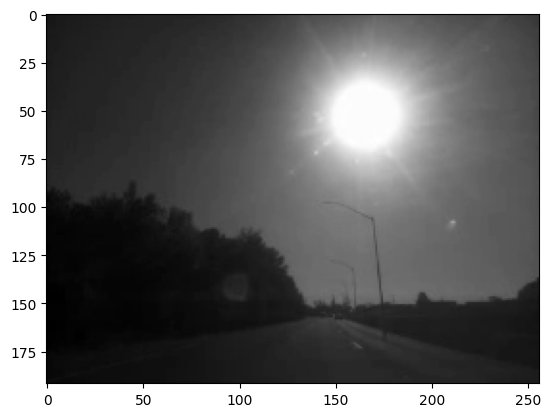

In [14]:
import matplotlib.pyplot as plt
plt.imshow(frame_input_sample[0,:,:,3],cmap='gray')
plt.show()

In [9]:
frame_input_sample.shape

TensorShape([8, 192, 256, 4])

# Do an overfit on a small dataset

In [7]:
test_epochs = 10
history = fpm.fit(train_ds_small,epochs=test_epochs, verbose=True,steps_per_epoch=112)

Epoch 1/10


 31/112 [=======>......................] - ETA: 25s - loss: 0.0030

KeyboardInterrupt: 

In [21]:
tmp = next(iter(train_ds_small()))

TypeError: '_PrefetchDataset' object is not callable

In [80]:
optimizer.learning_rate = 1e-5

In [81]:
history = fpm.fit(train_ds_small,epochs=test_epochs, verbose=1,steps_per_epoch=112)

Epoch 1/10
112/112 [==============================] - 39s 348ms/step - loss: 0.0181 - r2: -0.0409
Epoch 2/10
112/112 [==============================] - 39s 348ms/step - loss: 0.0178 - r2: -0.0338
Epoch 3/10
112/112 [==============================] - 39s 349ms/step - loss: 0.0177 - r2: -0.0329
Epoch 4/10
112/112 [==============================] - 39s 349ms/step - loss: 0.0178 - r2: -0.0317
Epoch 5/10
112/112 [==============================] - 39s 349ms/step - loss: 0.0178 - r2: -0.0316
Epoch 6/10
112/112 [==============================] - 40s 354ms/step - loss: 0.0177 - r2: -0.0317
Epoch 7/10
112/112 [==============================] - 39s 352ms/step - loss: 0.0178 - r2: -0.0320
Epoch 8/10
112/112 [==============================] - 38s 340ms/step - loss: 0.0178 - r2: -0.0294
Epoch 9/10
112/112 [==============================] - 38s 336ms/step - loss: 0.0177 - r2: -0.0303
Epoch 10/10
112/112 [==============================] - 39s 346ms/step - loss: 0.0177 - r2: -0.0314


In [86]:
input, output = next(iter(train_ds_small))

ex1 = fpm(input)

In [98]:
input[0].numpy()[0,:,:,:].squeeze().shape

(192, 256, 12)

In [ ]:
input

In [107]:
input[1][0]

<tf.Tensor: shape=(28,), dtype=float32, numpy=
array([-0.1360946 ,  2.6358507 , -0.13310656,  0.66286063,  1.0972971 ,
        0.09600986,  0.5013749 , -0.1360946 ,  2.6358507 , -0.13310656,
        0.66286063,  1.0972971 ,  0.09600986,  0.34872684, -0.1360946 ,
        2.6358507 , -0.13310656,  0.66286063,  1.0972971 ,  0.09600986,
       -0.24518125, -0.1360946 ,  2.6358507 , -0.13310656,  0.66286063,
        1.0972971 ,  0.09600986,  0.04735185], dtype=float32)>

In [108]:
input[1][1]

<tf.Tensor: shape=(28,), dtype=float32, numpy=
array([-0.1360946 ,  2.6358507 , -0.13310656,  0.66286063,  1.0972971 ,
        0.09600986, -0.03645438, -0.1360946 ,  2.6358507 , -0.13310656,
        0.66286063,  1.0972971 ,  0.09600986, -0.11709915, -0.1360946 ,
        2.6358507 , -0.13310656,  0.66286063,  1.0972971 ,  0.09600986,
       -0.14059892, -0.1360946 ,  2.6358507 , -0.13310656,  0.66286063,
        1.0972971 ,  0.09600986,  0.07185117], dtype=float32)>

In [109]:
input[1][2]

<tf.Tensor: shape=(28,), dtype=float32, numpy=
array([-0.1360946 ,  2.6358507 , -0.13310656,  0.66286063,  1.0972971 ,
        0.09600986,  0.08903697, -0.1360946 ,  2.6358507 , -0.13310656,
        0.66286063,  1.0972971 ,  0.09600986,  0.11516085, -0.1360946 ,
        2.6358507 , -0.13310656,  0.66286063,  1.0972971 ,  0.09600986,
       -0.01960179, -0.1360946 ,  2.6358507 , -0.13310656,  0.66286063,
        1.0972971 ,  0.09600986, -0.02587992], dtype=float32)>

In [142]:
# for plotting predicted frame
from PIL import Image
import time
import psutil

for _ in range(3):
    input, output = next(iter(train_ds_small))
    ex1 = fpm(input)
    data = ex1.numpy()[0,:,:,:3].squeeze()
    data = (data*255).astype(np.uint8)
    im = Image.fromarray(data)
    im.show()
    time.sleep(0.5)
    for proc in psutil.process_iter():
        if proc.name() == "display":
            proc.kill()

/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /home/ji/snap/code/common/.cache/gio-modules/libgiolibproxy.so
/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /home/ji/snap/code/common/.cache/gio-modules/libgiolibproxy.so
/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /home/ji/snap/code/common/.cache/gio-modules/libgiolibproxy.so


In [90]:
im.close()